# Projet Python Avancé - MOSEF
### Réalisé par El Mehdi Ouizza et Alexia Zounias-Sirabella

## On importe les packages nécessaires dans la suite du code

In [1]:
# Import des packages
import pandas as pd
import requests
from lxml import html
from unidecode import unidecode
from bs4 import BeautifulSoup
import urllib
import re
import matplotlib.pyplot as plt
import numpy as np
from threading import Thread
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Etape 1 : Récupération des informations du site pour initialiser la base

In [2]:
url_site = """https://www.pimkie.fr/c-toute-la-collection"""

Nous avons choisi ce site de vêtements de femmes. Durant cette première partie, nous allons récolter diverses informations comme les catégories, sous-catégories, nombre de produits, prix des produits, etc ... Pour cela, nous allons créer diverses fonctions.

Ces informations seront rentrées dans la base par la suite.

In [3]:
def recup_categorie(url):
    """
    Cette fonction, appliquée à l'accueil du site, permet de récupérer les grandes catégories des produits vendus.
    Elle retourne les listes Categorie, Categorie_url et Nb_Art_Categorie permettant d'initialiser la base.
    """
    # Ouvrir l'URL
    soup = BeautifulSoup(urllib.request.urlopen(url))
    # Stockage des informations
    Categorie = []
    Categorie_url = []
    Nb_Art_Categorie = []
    for a in soup.find_all('li', class_="category-element"): 
        p = re.compile('title="(.[^#<#\n]+)"',re.IGNORECASE) # Récupérer les noms des catégories
        match = p.findall(str(a))
        if (match != [] and match[0] not in Categorie): # La page peut contenir plusieurs liens vers la même catégorie
            Categorie.append(match[0])
        p = re.compile('href="(.[^#"#\n]+)"',re.IGNORECASE) # Récupérer les url des pages des catégories
        match = p.findall(str(a))
        if (match != [] and match[0] not in Categorie_url):
            Categorie_url.append(match[0])
        p = re.compile('[0-9]+',re.IGNORECASE) # Récupérer les nombres de produits
        match = p.findall(str(a))
        if match != []:
            Nb_Art_Categorie.append(int(match[0]))
    Nb_Art_Categorie = Nb_Art_Categorie[0:len(Categorie)] # Permet d'enlever les doublons
    return(Categorie, Categorie_url, Nb_Art_Categorie)

In [4]:
# Appel de la fonction
Categorie, Categorie_url, Nb_Art_Categorie = recup_categorie(url_site)

Cette étape étant la première, nous avons préféré afficher les résultats afin de pouvoir les vérifier.

In [5]:
# Vérification des résultats
print(Categorie)
print("##################################")
print(Categorie_url)
print("##################################")
print(Nb_Art_Categorie)

['Veste', 'Jean', 'Tshirt et top', 'Robe', 'Blouse et chemise', 'Jupe', 'Pantalon', 'Pull et gilet', 'Manteau', 'Combinaison', 'Short', 'Toute la collection']
##################################
['https://www.pimkie.fr/c-veste', 'https://www.pimkie.fr/c-jean', 'https://www.pimkie.fr/c-tshirt-et-top', 'https://www.pimkie.fr/c-robe', 'https://www.pimkie.fr/c-blouse-et-chemise', 'https://www.pimkie.fr/c-jupe', 'https://www.pimkie.fr/c-pantalon', 'https://www.pimkie.fr/c-pull-et-gilet', 'https://www.pimkie.fr/c-manteau', 'https://www.pimkie.fr/c-combinaison', 'https://www.pimkie.fr/c-short', 'https://www.pimkie.fr/c-toute-la-collection']
##################################
[45, 44, 104, 33, 46, 27, 23, 81, 19, 1, 6, 552]


In [6]:
# La catégorie "Toute la collection" ne sera pas utile dans la suite
nb_categorie = len(Categorie)
Categorie = Categorie[0:nb_categorie - 1] # On enlève le dernier élément qui correspond à "Toute la collection"
Categorie_url = Categorie_url[0:nb_categorie - 1]
Nb_Art_Categorie = Nb_Art_Categorie[0:nb_categorie - 1]

Le nombre d'articles par catégorie permet d'initialiser la base avec le bon nombre de lignes, cela ne sera pas stocké dans le dataframe par la suite. En revanche, il peut être intéressant de connaître la catégorie de chaque article et les URLs vont nous permettre de naviguer entre les pages.

## Etape 2 : Création d'une base avec les premières informations

In [7]:
# Nous allons remplir ces colonnes au fur et à mesure de cette étape
colonnes = ['Nom','URL', 'Prix', 'Couleur', 'Sous_Catégorie', 'Catégorie_Identifiant', 'Catégorie','Catégorie_url']
# Une ligne correspondra à un produit
row = []
compteur = 0
for i in Nb_Art_Categorie:
    for j in range(i):
        # La ligne sera vide exceptées les informations déjà connues (ex : catégorie du produit)
        row.append(("","", "", "", "",j, Categorie[compteur], Categorie_url[compteur]))
    compteur += 1

In [8]:
# Création du dataframe
df = pd.DataFrame() # Création du dataframe vide
df = df.from_records(row, columns = colonnes) # remplissage du dataframe

In [9]:
df.head(5)

,Nom,URL,Prix,Couleur,Sous_Catégorie,Catégorie_Identifiant,Catégorie,Catégorie_url
0,,,,,,0,Veste,https://www.pimkie.fr/c-veste
1,,,,,,1,Veste,https://www.pimkie.fr/c-veste
2,,,,,,2,Veste,https://www.pimkie.fr/c-veste
3,,,,,,3,Veste,https://www.pimkie.fr/c-veste
4,,,,,,4,Veste,https://www.pimkie.fr/c-veste


Comme on peut le voir, la plupart des colonnes sont vides. Chaque ligne correspond à un produit dont nous allons récupérer les informations. pour le moment, nous avons seulement sa catégorie et son placement dans la page de sa catégorie.

## Etape 3 : Remplissage de la base

Pour faire cela, nous avons tout d'abord créer deux fonctions qui seront ensuite appliquer aux dataframes. la première permet de récupérer le nom des produits ainsi que leur URL. La deuxième, doit être appliquée après la première (besoin de l'URL du produit) et renvoie diverses informations sur le produit.

In [10]:
def recup_nom_url(df):
    """
    Cette fonction, appliquée au dataframe (où les URLs des catégories doivent être renseignés), 
    permet de récupérer le nom et l'URL des produits vendus.
    """
    if df.Catégorie_Identifiant < 42: #Sinon l'url doit être modifié
        url = df.Catégorie_url
        # Ouvrir l'URL
        soup = BeautifulSoup(urllib.request.urlopen(url))
        a = soup.find_all('div',class_="product-name")[df.Catégorie_Identifiant] # Classe détaillant les produits présentés
        p = re.compile('title="(.[^#<#\n]+)"',re.IGNORECASE) # Récupérer les noms des produits
        match = p.findall(str(a))
        if (match != []): # On a trouvé un produit
            df.Nom = match[0] # On entre son nom
        p = re.compile('href="(.[^#<#\n]+)"\s',re.IGNORECASE) # Récupérer les url des produits 
        match = p.findall(str(a))
        if (match != []):
            df.URL = match[0] # On le stocke
    else:
        url = df.Catégorie_url + "?sz=" + str(42 * (int(df.Catégorie_Identifiant/42) +1))+ "&start=" +\
        str(42 * int(df.Catégorie_Identifiant/42)) 
        # Sinon le site prend en compte automatiquement les 42 premiers produits
        # Ouvrir l'URL
        soup = BeautifulSoup(urllib.request.urlopen(url))
        a = soup.find_all('div',class_="product-name")[df.Catégorie_Identifiant - 42 *\
                        int(df.Catégorie_Identifiant/42)] # Classe détaillant les produits présentés
        p = re.compile('title="(.[^#<#\n]+)"',re.IGNORECASE) # Récupérer les noms des produits
        match = p.findall(str(a))
        if (match != []): # On a trouvé un produit
            df.Nom = match[0] # On entre son nom
        p = re.compile('href="(.[^#<#\n]+)"\s',re.IGNORECASE) # Récupérer les url des produits 
        match = p.findall(str(a))
        if (match != []):
            df.URL = match[0] # On le stocke
    
    return(df)

In [11]:
def autre_info(df):
    """
    Cette fonction, appliquée au dataframe (où les URLs des produits doivent être renseignés), 
    permet de récupérer la couleur, le prix et la sous-catégorie du produit.
    """
    url = df.URL
    # Ouvrir l'URL
    soup = BeautifulSoup(urllib.request.urlopen(url))
    # Récupération de la couleur
    a = soup.find('span',class_="text-color-uni") # On ne veut que le premier match
    p = re.compile('>(.[^#<#\n]+)<',re.IGNORECASE) 
    match = p.findall(str(a))
    if (match != []): 
        df.Couleur = match[0] # On la stocke
    else: # 2 patterns différents pour la couleur
        a = soup.find('img',class_="lazyload") # 2e possibilité
        p = re.compile(df.Nom + " " +'([a-zA-Zéè]+)',re.IGNORECASE) # Récupérer la couleur
        match = p.findall(str(a))
        if (match != []): 
            df.Couleur = match[0]
    # Récupération du prix
    a = soup.find('span',class_="plain") # On ne veut que le premier match
    p = re.compile('>([0-9]+)<',re.IGNORECASE) # Récupérer les nombres
    match = p.findall(str(a))
    if (match != []): 
        df.Prix = int(match[0]) # On le stocke
    # Récupération de la sous-catégorie
    a = soup.find('a',class_="refinement-link active")
    p = re.compile('>\n([^#<#\n]+)\n<',re.IGNORECASE) # Récupérer les sous-cat
    match = p.findall(str(a))
    if (match != []): # On a trouvé
        df.Sous_Catégorie = match[0]
    return df

Pour éviter un temps de calcul trop important, nous avons paralléliser le code en 10 threads. Les traitements étant indépendants, cela était possible.

In [12]:
class Calcul(Thread):

    """Thread chargé d'appliquer les fonctions au dataframe."""

    def __init__(self, data):
        Thread.__init__(self)
        self.data = data
        

    def run(self):
        """Code à exécuter pendant l'exécution du thread."""
        self.data = self.data.apply(recup_nom_url, axis = 1) # applique la fonction à chaque ligne
        self.data = self.data.apply(autre_info, axis = 1)

# Création des threads
N = int(len(df)/10)
thread_1 = Calcul(df[0:N])
thread_2 = Calcul(df[N:2*N])
thread_3 = Calcul(df[2*N:3*N])
thread_4 = Calcul(df[3*N:4*N])
thread_5 = Calcul(df[4*N:5*N])
thread_6 = Calcul(df[5*N:6*N])
thread_7 = Calcul(df[6*N:7*N])
thread_8 = Calcul(df[7*N:8*N])
thread_9 = Calcul(df[8*N:9*N])
thread_10 = Calcul(df[9*N:len(df)])

In [13]:
# Lancement des threads
thread_1.start()
thread_2.start()
thread_3.start()
thread_4.start()
thread_5.start()
thread_6.start()
thread_7.start()
thread_8.start()
thread_9.start()
thread_10.start()

# Attend que les threads se terminent
thread_1.join()
thread_2.join()
thread_3.join()
thread_4.join()
thread_5.join()
thread_6.join()
thread_7.join()
thread_8.join()
thread_9.join()
thread_10.join()

On regroupe ensuite les résultats pour reconstituer la base

In [14]:
df = pd.concat([thread_1.data, thread_2.data, thread_3.data, thread_4.data, thread_5.data, \
           thread_6.data, thread_7.data, thread_8.data, thread_9.data, thread_10.data], axis=0)

Aperçu de la base :

In [15]:
df.head(60)

,Nom,URL,Prix,Couleur,Sous_Catégorie,Catégorie_Identifiant,Catégorie,Catégorie_url
0,Veste en jean courte,https://www.pimkie.fr/p/veste-en-jean-courte-3...,29,rose,veste en jean,0,Veste,https://www.pimkie.fr/c-veste
1,Veste en jean,https://www.pimkie.fr/p/veste-en-jean-32339068...,29,bleu,veste en jean,1,Veste,https://www.pimkie.fr/c-veste
2,Veste courte à poches,https://www.pimkie.fr/p/veste-courte-a-poches-...,29,blanc cassé,veste en jean,2,Veste,https://www.pimkie.fr/c-veste
3,Veste en jean en matière recyclée,https://www.pimkie.fr/p/veste-en-jean-en-matie...,29,noir,veste en jean,3,Veste,https://www.pimkie.fr/c-veste
4,Blazer à rayures,https://www.pimkie.fr/p/blazer-a-rayures-32335...,29,bleu,blazer,4,Veste,https://www.pimkie.fr/c-veste
5,Blazer pied de poule,https://www.pimkie.fr/p/blazer-pied-de-poule-3...,29,noir,blazer,5,Veste,https://www.pimkie.fr/c-veste
6,Blazer fin,https://www.pimkie.fr/p/blazer-fin-323375E20A0...,25,beige,blazer,6,Veste,https://www.pimkie.fr/c-veste
7,Veste suédine,https://www.pimkie.fr/p/veste-suedine-32338727...,29,rose,Veste légère,7,Veste,https://www.pimkie.fr/c-veste
8,Veste en jean courte,https://www.pimkie.fr/p/veste-en-jean-courte-3...,29,bleu,veste en jean,8,Veste,https://www.pimkie.fr/c-veste
9,Veste suédine,https://www.pimkie.fr/p/veste-suedine-323387D1...,29,camel,Veste légère,9,Veste,https://www.pimkie.fr/c-veste


## Etape 4 : Analyser les informations récupérées

Dans cette partie, nous allons exclure des informations, comme les URLs, qui n'ont été utiles que pour la partie Web Scraping.

In [16]:
data = df[['Nom', 'Prix', 'Couleur', 'Sous_Catégorie', 'Catégorie']]

In [17]:
data.head()

,Nom,Prix,Couleur,Sous_Catégorie,Catégorie
0,Veste en jean courte,29,rose,veste en jean,Veste
1,Veste en jean,29,bleu,veste en jean,Veste
2,Veste courte à poches,29,blanc cassé,veste en jean,Veste
3,Veste en jean en matière recyclée,29,noir,veste en jean,Veste
4,Blazer à rayures,29,bleu,blazer,Veste


#### 1) Description des données

In [18]:
data.describe(include=[np.object])

,Nom,Couleur,Sous_Catégorie,Catégorie
count,429,429,429,429
unique,205,41,39,11
top,Jean skinny mid waist,noir,tshirt,Tshirt et top
freq,9,131,79,104


Cette première description nous permet de voir que les noms des produits ne sont pas uniques. Par ailleurs, la couleur la plus présente est le noir ainsi que la catégorie et la sous-catégorie les plus peuplées sont celles des tee-shirt. Ces premiers résultats ne sont pas suprenants et peuvent nous conforter sur la fiabilité des données récupérées.

In [19]:
data.describe()

,Prix
count,429.00000
mean,22.13986
std,10.69278
min,4.00000
25%,15.00000
50%,19.00000
75%,29.00000
max,69.00000


Cette deuxième desciption nous permet d'avoir les informations sur le prix des articles, qui est une variable quantitative contrairement aux autres.

#### 2) Regroupement par catégorie

In [20]:
data_categorie = data.groupby(by = "Catégorie").count()

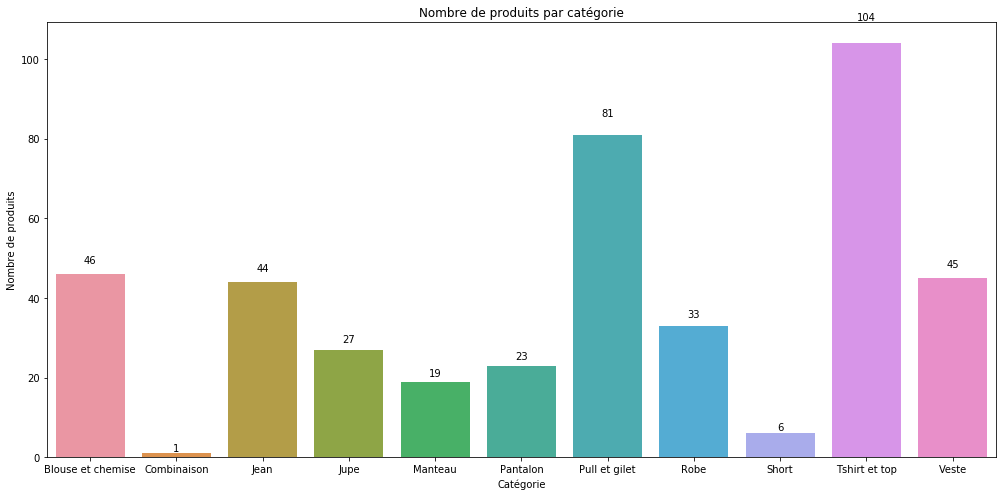

In [21]:
fig, ax = plt.subplots(1, figsize=(17, 8))
bar_plot = plt.bar(np.arange(len(data_categorie)), data_categorie.Nom)
plt.xticks(np.arange(len(data_categorie)), data_categorie.index)
bar_label = data_categorie.Nom
for idx,rect in enumerate(bar_plot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            bar_label[idx],
                ha='center', va='bottom', rotation=0)
bar_plot = sns.barplot(data_categorie.index.tolist(), data_categorie.Nom) 
plt.title("Nombre de produits par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de produits")
plt.show()

Cette visualisation nous permet de voir le nombre d'articles par catégorie. On constate donc que certaines catégories ont plus de produits que d'autres.

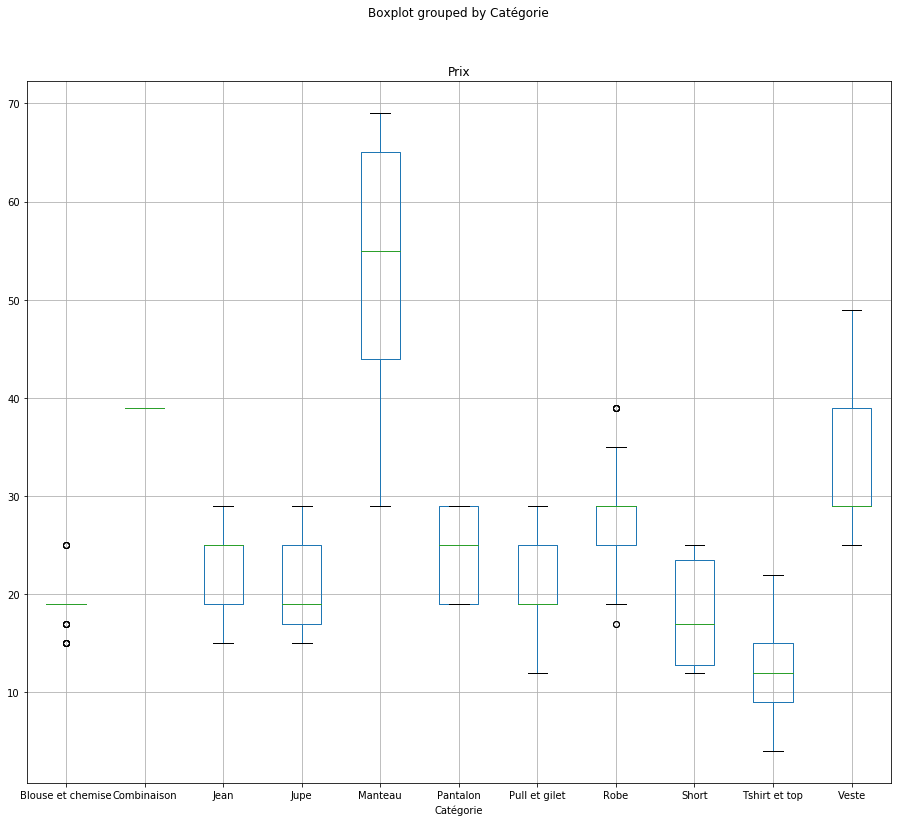

In [22]:
boxplot = data.boxplot(column=['Prix'], by = 'Catégorie', figsize=(15, 13))

Grâce à ces boîtes à moustache selon la catégorie des articles, on peut voir que les manteaux, par exemple, sont en général plus chers que les autres articles.

#### 3) Regroupement par couleur

In [23]:
data_couleur = data.groupby(by = "Couleur").count()

Etant donné le nombre important de couleurs,nous n'allons garder que les couleurs ayant plus de quatres articles.

In [24]:
data_couleur = data_couleur[data_couleur.Nom > 4]

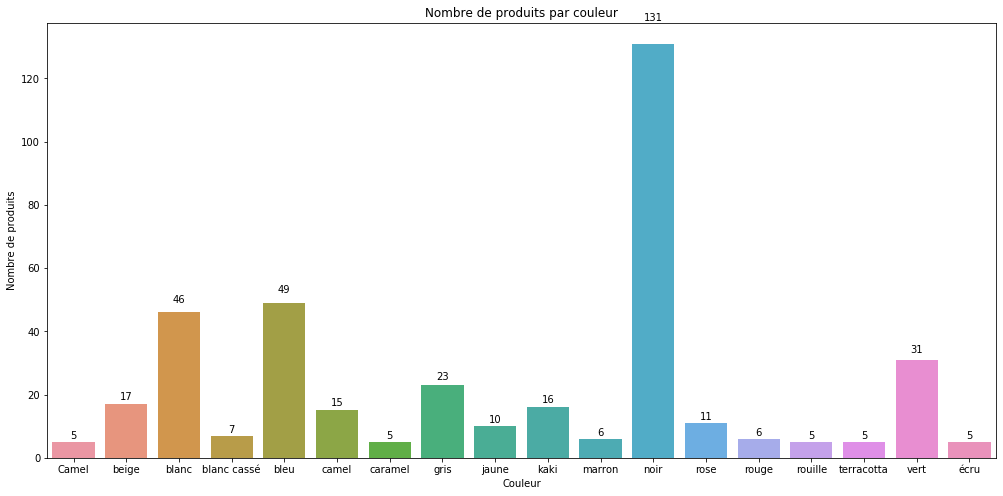

In [25]:
fig, ax = plt.subplots(1, figsize=(17, 8))
barplot = plt.bar(data_couleur.index.tolist(), data_couleur.Nom)
plt.xticks(data_couleur.index.tolist(), data_couleur.Nom)
bar_label = data_couleur.Nom
for idx,rect in enumerate(barplot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            bar_label[idx],
                ha='center', va='bottom', rotation=0)
bar_plot = sns.barplot(data_couleur.index.tolist(), data_couleur.Nom) #color = data_couleur.Nom.values, palette='Reds_d')
plt.title("Nombre de produits par couleur")
plt.xlabel("Couleur")
plt.ylabel("Nombre de produits")
plt.show()

On voit donc clairement une préférence pour certaines couleur comme le noir, le bleu, le blanc ou le vert.

In [26]:
data_couleur = data[data['Couleur'].isin(data_couleur.index.tolist())]

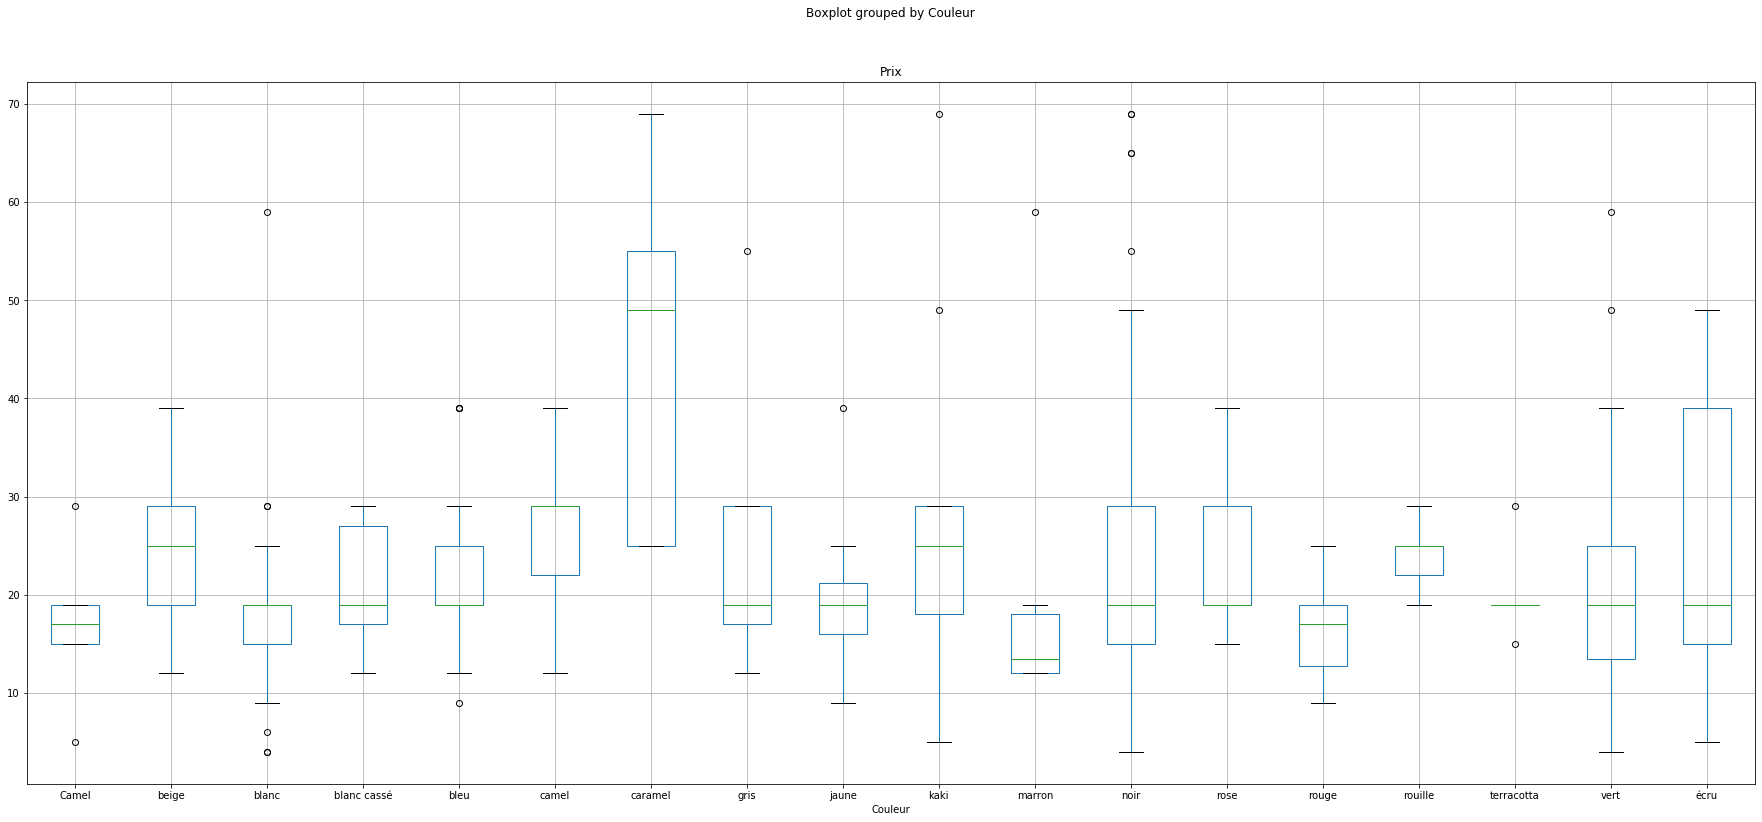

In [27]:
boxplot = data_couleur.boxplot(column=['Prix'], by = 'Couleur', figsize=(30, 13))

On peut voir la distribution des prix en fonction des couleurs (comptant plus d'un minimum d'articles).
On peut constater une légère hausse des prix pour des couleurs telles que le caramel.

## Etape 5 : Prédiction du prix

La variable à prédire étant quantitative (le prix), nous allons utiliser une régression linéaire.

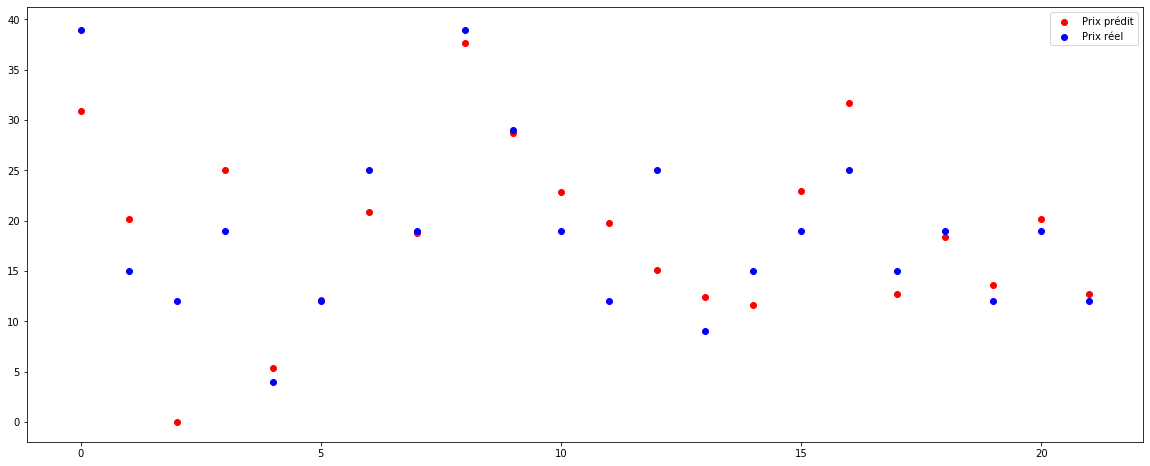

In [28]:
labels = data.Prix # cible
reg = LinearRegression() # Initialisation du modèle
data_pred = data.drop(['Prix', 'Nom'], axis = 1) # On enlève la cible et le nom (inutile ici)
data_pred = pd.get_dummies(data_pred) # Pour pouvoir appliquer la régression avec des variables qualitatives
# On sépare nos données pour avoir des données d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(data_pred, labels, test_size = 0.05, random_state = 2)
reg.fit(x_train, y_train) # Entraînement du modèle
pred = reg.predict(x_test) # Prédiction
result = []
for i in range(len(pred)):
    if abs(pred[i]) > 200:
        result.append(0)
    else:
        result.append(pred[i])
# Le graphique permet de voir la différence entre le prix prédit (en rouge) et le prix réel (en rouge)
fig, ax = plt.subplots(1, figsize=(20, 8))
scat1 = plt.scatter(range(len(y_test)), result, c = 'red')
scat2 = plt.scatter(range(len(y_test)), y_test, c = 'blue')
plt.legend([scat1, scat2], ['Prix prédit', 'Prix réel'])
plt.show()

On procède à quelques vérifications de performance.

In [30]:
perte = []
perte_carré = []
for i in range(len(y_test)):
    perte.append(abs(y_test.values[i] - result[i]))
    perte_carré.append((y_test.values[i] - result[i])**2)
print('La différence maximale est : ' + str(max(perte)))
print('La différence moyenne est : ' + str(np.mean(perte)))
print('La différence minimale est : ' + str(min(perte)))
print("L'écart-type est de : " + str(np.sqrt(np.sum(perte_carré)/len(y_test))))

La différence maximale est : 12
La différence moyenne est : 3.8238636363636362
La différence minimale est : 0.125
L'écart-type est de : 5.045601707518053
